### Springboard CapstoneOne: Market Basket Analysis

Exploratory Data Analysis (EDA) - Item Reorder time Gap

NOTE: The raw data contains orderes.days_since_prior_order.  However, this does not reflect the time between individual items, since a user may not purchase the item in every order.  Therefore, here we calculate the time gap between individual items.  The process is compute intensive, so is separated from the main EDA.

#### -- Rose Zdybel

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns


In [2]:
# read in data
#aisles = pd.read_csv('data\\aisles.csv')
#departments = pd.read_csv('data\\departments.csv')
orders = pd.read_csv('data\\orders.csv')
order_products__prior = pd.read_csv('data\\order_products__prior.csv')
#order_products__train = pd.read_csv('data\\order_products__train.csv')
products = pd.read_csv('data\\products.csv')
departments = pd.read_csv('data\\departments.csv')




# Use FULL Data set

In [3]:
xop = order_products__prior
xorders = orders

# Process Data

In [4]:
# extract relevant information from orders, and calculate running_order_days

ordertemp = xorders[['order_id','user_id','order_number','days_since_prior_order']]
 
ordertemp['running_order_days'] = ordertemp.groupby('user_id').days_since_prior_order.cumsum()
ordertemp.head()

C:\Users\rozoe\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,order_id,user_id,order_number,days_since_prior_order,running_order_days
0,2539329,1,1,NaN,NaN
1,2398795,1,2,15.0,15.0
2,473747,1,3,21.0,36.0
3,2254736,1,4,29.0,65.0
4,431534,1,5,28.0,93.0


In [5]:
# merge order information with order-products, and sort in preparation for running value calculations

itemgap = pd.merge(ordertemp, xop [['order_id', 'product_id', 'reordered']], on='order_id')

itemgap.sort_values(['user_id','product_id','order_number'], inplace=True)

In [6]:
# calculate an array of differences for reordered products, and transform to a dataframe

ztemp = itemgap.groupby(['user_id', 
                         'product_id', 
                         'order_number'])['running_order_days'].sum().groupby(level=[0, 1]).apply(lambda x: np.diff(np.nan_to_num(x)))

ztemp = ztemp.to_frame('periods').reset_index()


In [7]:
# extract the index to be used for accessing the gap array items


itemgap['running_item_seq'] = itemgap[itemgap.reordered ==1].groupby(['user_id', 'product_id'])['reordered'].cumcount()


In [8]:
# merge the temp information

itemgapperiods = pd.merge(ztemp, itemgap)

In [9]:
# finally... calculate the item_lapsed time....
itemgapperiods['item_lapse'] = itemgapperiods[itemgapperiods.reordered==1].apply(lambda row: row.periods[int(row.running_item_seq)], axis=1 )


In [10]:
# save the results to a file, for future reference, if needed.

#itemgapperiods.to_csv('itemDaysDelatTime')


In [11]:
# extract reordered  products and decode
rop = itemgapperiods[itemgapperiods.reordered==1][['user_id','product_id','order_id','order_number','item_lapse']]
ropDecode=pd.merge(pd.merge(rop, products), departments)

# EDA for the item time Gaps

## Gap frequency

Text(0, 0.5, 'Time Gap (Days)')

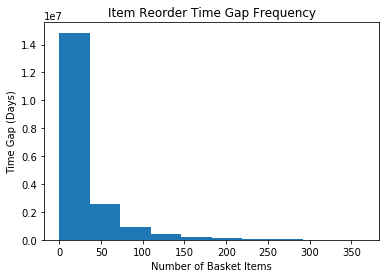

In [12]:
plt.hist(rop.item_lapse)

 
plt.title('Item Reorder Time Gap Frequency')
plt.xlabel('Number of Basket Items')
plt.ylabel('Time Gap (Days)')


Text(0, 0.5, 'Time Gap (Days)')

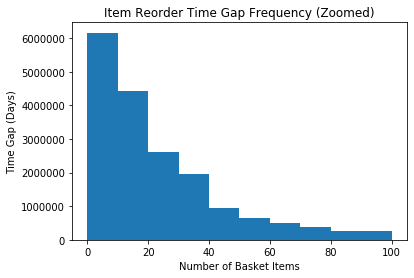

In [13]:
# Zoom in

plt.hist(rop.item_lapse, range=[0, 100])

 
plt.title('Item Reorder Time Gap Frequency (Zoomed)')
plt.xlabel('Number of Basket Items')
plt.ylabel('Time Gap (Days)')

##  Item Time Gap by Dept

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20]), <a list of 21 Text xticklabel objects>)

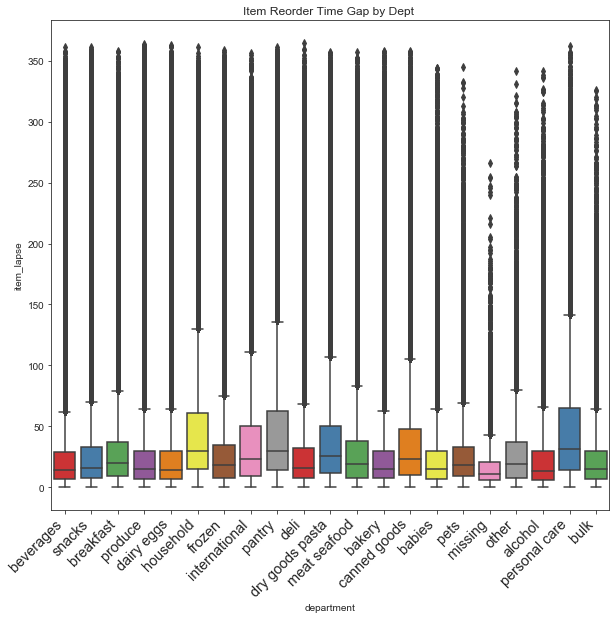

In [14]:
# lapsed time by DEPT 
 
sns.set_style('ticks')
fig, ax = plt.subplots()
# set size
fig.set_size_inches(10, 9)

sns.boxplot(x="department", y="item_lapse", 
            data=ropDecode, 
            palette="Set1")

plt.title('Item Reorder Time Gap by Dept ')

plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
)

In [15]:
# median times by department

#ropDecode.groupby('department').item_lapse.median().sort_values()


ropMedianQuantity = ropDecode.groupby('department').agg(lapsed_median=('item_lapse','median' ), 
                                    item_count=('order_id','count')).sort_values('item_count',ascending=False)
ropMedianQuantity

,lapsed_median,item_count
department,,
produce,15.0,6160710
dairy eggs,14.0,3627221
beverages,14.0,1757892
snacks,16.0,1657973
frozen,18.0,1211890
bakery,15.0,739188
pantry,30.0,650301
deli,16.0,638864
canned goods,23.0,488535


Text(0, 0.5, 'Gap Medain (days)')

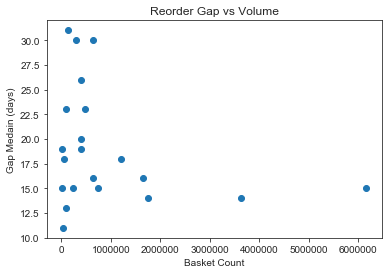

In [16]:
plt.scatter(x=ropMedianQuantity.item_count, y = ropMedianQuantity.lapsed_median)
plt.title('Reorder Gap vs Volume')
plt.xlabel('Basket Count')
plt.ylabel('Gap Medain (days)')

In [17]:
ropMedianQuantity.sort_values('lapsed_median')

,lapsed_median,item_count
department,,
missing,11.0,27371
alcohol,13.0,87595
dairy eggs,14.0,3627221
beverages,14.0,1757892
produce,15.0,6160710
bakery,15.0,739188
bulk,15.0,19950
babies,15.0,245369
snacks,16.0,1657973
